<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/multivariate_statistical_forecacst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

##Kernel setup

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%capture
!git clone https://github.com/Krankile/npmf.git
!pip install wandb
!pip install pmdarima

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


##General setup

In [ ]:
%%capture
!cd npmf && git pull

import os
import pickle
from collections import defaultdict, OrderedDict
from datetime import datetime
from operator import itemgetter

import numpy as np
from numpy.ma.core import outerproduct
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import pmdarima as pm

import wandb as wb

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from npmf.utils.colors import main, main2, main3
from npmf.utils.wandb import get_dataset, put_dataset, put_models, get_models
from npmf.utils.data import test_start_pd, get_1_month_test_set, get_train_set
from npmf.utils.measurement import mape
from npmf.utils.eikon import col_map_macro

In [ ]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[main, main2, main3, "black"])
mpl.rcParams['figure.figsize'] = (12, 4)  # (6, 4) is default and used in the paper
pd.DataFrame.np = lambda self: self.to_numpy()
pd.Series.np = lambda self: self.to_numpy()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
np.random.seed(420)

In [ ]:
def plot_market_cap(df):
    plt.plot(df.date.to_numpy(), df.market_cap.to_numpy())

# Initial validation on synthetic data



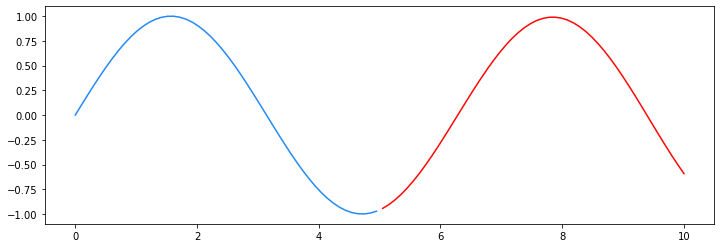

In [ ]:
mod = pm.arima.AutoARIMA(seasonal=False)

xs = np.linspace(0, 10, 100)
ys = np.sin(xs)


mod.fit(ys[:-50])

fs = mod.predict(50)

plt.plot(xs[:-50], ys[:-50])
plt.plot(xs[-50:], fs)

In [ ]:
def plot_pred(ax, xs, ys, f1, f2, text=""):
    ax.text(0, 3, text, va="top", ha="left", size=14)
    ax.plot(xs, ys, label="Data")
    ax.plot(xs, f1, linestyle="-.")
    ax.plot(10 + xs, f2, linestyle="-.", color=main2, label="Forecast")

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/arima.py:692: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "
/usr/local/lib/python3.7/dist-packages/pmdarima/arima/arima.py:692: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "
/usr/local/lib/python3.7/dist-packages/pmdarima/arima/arima.py:692: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


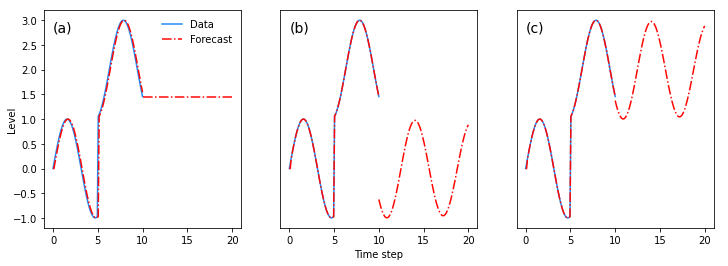

In [ ]:
mod = pm.arima.AutoARIMA(seasonal=False)
xs = np.linspace(0, 10, 100)
x1 = np.concatenate((np.zeros(50), np.ones(50)))
ys = np.sin(xs) + 2 * x1

fig = plt.figure()
ax = fig.add_subplot(111)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

mod.fit(ys)
f1 = mod.predict_in_sample()
f2 = mod.predict(100)
plot_pred(ax1, xs, ys, f1, f2, "(a)")

mod.fit(ys, x1.reshape((100, 1)))
f1 = mod.predict_in_sample(x1.reshape((100, 1)))
f2 = mod.predict(100, np.zeros((100, 1)))
plot_pred(ax2, xs, ys, f1, f2, "(b)")

mod.fit(ys, x1.reshape((100, 1)))
f1 = mod.predict_in_sample(x1.reshape((100, 1)))
f2 = mod.predict(100, np.ones((100, 1)))
plot_pred(ax3, xs, ys, f1, f2, "(c)")
ax1.legend(frameon=False)
ax2.axes.yaxis.set_visible(False)
ax3.axes.yaxis.set_visible(False)

ax.set_xlabel("Time step")
ax.set_ylabel("Level")

fig.add_axes(xlabel="Time step")

# Fit ARIMAX for all tickers

## Get data and prepare

### Download from WandB

In [ ]:
def get_all_data():
    all_stck = get_dataset("stock-oil-final:v4", "master-test").set_index(["ticker", "date"]).sort_index()
    all_fund = (
        get_dataset("fundamentals-oil-final:v4", "master-test")
        .astype(
            {
                "date": np.datetime64,
                "period_end_date": np.datetime64,
                "announce_date": np.datetime64,
            }
        )
        .set_index(["ticker", "announce_date"])
        .drop(columns=["period_end_date"])
        .sort_index()
    )
    all_macr = get_dataset("macro-oil-final:v1", "master-test").set_index("date").sort_index().rename(columns=col_map_macro)

    print(f"Shape stock: {all_stck.shape}, shape fundamental: {all_fund.shape}, shape macro: {all_macr.shape}")
    
    all_stck = all_stck[~all_stck.index.duplicated(keep="first")]
    all_fund = all_fund[~all_fund.index.duplicated(keep="last")]
    
    return all_stck, all_fund, all_macr

def get_training_data(all_data: list = None):

    if all_data is None:
        s, f, m = get_all_data()
    else:
        s, f, m = all_data
    
    stck = s[s.index.get_level_values(1) < test_start_pd]
    fund = f[f.index.get_level_values(1) < test_start_pd]
    macr = m[m.index < test_start_pd]

    return stck, fund, macr

In [ ]:
stck, fund, macr = get_training_data()

tickers = fund.index.levels[0]


## Create the training procedure

Create the procedure in such a way that it drops constant columns because they carry no actionable information and causes the ARIMAX model to crash epically.

In [ ]:
def get_arimax_training_data(
    stck: pd.DataFrame, fund: pd.DataFrame, macr: pd.DataFrame, ticker: str, tw: int = 60,
):
    s = stck.loc[(ticker,)]
    f = fund.loc[(ticker,)]

    s = (
        s.join(f, how="left", rsuffix="_fund")
        .join(macr, how="left", rsuffix="_macr")
        .ffill()
    )
    s = s.iloc[-tw:, :]

    ys = s.market_cap
    exs = s.drop(columns=["market_cap", "close_price", "currency", "date"])
    exs = exs.loc[:, exs.nunique() > 1].dropna()

    return ys, exs

In [ ]:
models = dict()
errors = []

arima_args = dict(seasonal=False, error_action="ignore", n_jobs=1, stepwise=True, with_intercept=True)

it = tqdm(tickers[:10], desc="Training ARIMAX", postfix=dict(errors=len(errors)))

for ticker in it:
    try:

        ys, exs = get_arimax_training_data(stck, fund, macr, ticker, 240)

        ex_cols = exs.columns.to_list()

        mod = pm.arima.AutoARIMA(**arima_args)
        mod.fit(ys, exs.np())

        models[ticker] = (mod, ex_cols)

    except Exception as e:
        errors.append((ticker, e))
        it.set_postfix(dict(errors=len(errors)))

Training ARIMAX: 100%|██████████| 10/10 [03:32<00:00, 21.26s/it, errors=0]


## Save the trained models to WandB

In [ ]:
filename = "arimax-trained-4Q.pickle"
metadata = {
    "type": "ARIMAX",
    "n_models": len(models),
    "macro": True,
    "fundamentals": True,
    "training_window": 240,
    "arima_args": arima_args,
}

put_models(filename, models, metadata)

# Test the fitted models on the test set

## Get the models from WandB

In [ ]:
models = get_models("arimax-trained-4Q:v0")

wandb: Currently logged in as: ankile (krankile). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact arimax-trained-4Q:v0, 315.92MB. 1 files... Done. 0:0:0


In [ ]:
%%capture
all_stck, all_fund, all_macr = get_all_data()
stck, fund, macr = get_training_data([all_stck, all_fund, all_macr])

## Predict for January 2019

In [ ]:
ob_num = list(range(1, 21))
out = dict(ticker=[], market_cap=[], obs_number=[])

# Get last fundamental values for use in forecasting
fund_exo = (
    fund.reset_index()
    .drop_duplicates(subset="ticker", keep="last")
    .set_index("ticker")
    .drop(columns=["date", "announce_date"])
    .fillna(0)
)

# Get last macro data
macr_exo = macr.ffill().iloc[-1, :]


for ticker, (model, columns) in tqdm(models.items()):

    exo = pd.concat(
        [fund_exo.loc[ticker, :], macr_exo],
        axis=0,
    )[columns]

    exo = np.repeat(exo.np().reshape((1, -1)), 20, axis=0)

    forec = model.predict(20, exo)
    ts = [ticker] * 20

    out["ticker"].extend(ts)
    out["market_cap"].extend(forec)
    out["obs_number"].extend(ob_num)


forec_df = pd.DataFrame(out)

put_dataset(
    forec_df,
    "arimax-4Q-forecast-2019M1.feather",
    "master-test",
    type_="forecast",
    metadata={"model": "ARIMAX", "n_forecasts": len(models), "training_window": 240},
)

forec_df = forec_df.set_index(["ticker", "obs_number"])

100%|██████████| 770/770 [00:04<00:00, 170.06it/s]


In [ ]:
forec_df

market_cap
ticker    obs_number              
000096.SZ 1           7.177950e+08
          2           7.204327e+08
          3           7.229668e+08
          4           7.254015e+08
          5           7.277406e+08
...                            ...
ZHEN.SI   16          5.207521e+08
          17          5.216346e+08
          18          5.224399e+08
          19          5.231748e+08
          20          5.238453e+08

[15400 rows x 1 columns]

## Create actual and compare

In [ ]:
tst = all_stck[all_stck.index.get_level_values(1) >= test_start_pd].reset_index()
tst["obs_number"] = tst.groupby("ticker").date.rank(method='first', ascending=True).astype(int)
tst = tst[tst.obs_number <= 20].set_index(["ticker", "obs_number"]).loc[:, ["market_cap"]]
tst.market_cap = tst.market_cap.astype(np.float64)
tst

market_cap
ticker    obs_number              
000096.SZ 1           6.935114e+08
          2           6.931595e+08
          3           7.005345e+08
          4           7.052744e+08
          5           7.127950e+08
...                            ...
ZHEN.SI   16          5.736022e+08
          17          5.939724e+08
          18          5.864256e+08
          19          5.869460e+08
          20          5.871631e+08

[17980 rows x 1 columns]

In [ ]:
tickers = forec_df.index.unique(level="ticker").intersection(tst.index.unique(level="ticker"))

tst = tst[tst.index.get_level_values(0).isin(tickers)]
forec_df = forec_df[forec_df.index.get_level_values(0).isin(tickers)]

In [ ]:
errors = ((tst - forec_df).abs() / tst.abs())
errors

market_cap
ticker    obs_number            
000096.SZ 1             0.035016
          2             0.039346
          3             0.032022
          4             0.028538
          5             0.020968
...                          ...
ZHEN.SI   16            0.092137
          17            0.121786
          18            0.109111
          19            0.108649
          20            0.107837

[15340 rows x 1 columns]

In [ ]:
errors.groupby("ticker").mean().mean().item()

45.635188892215545

# Analyze the resulting models

In [ ]:
models = get_models("arimax-trained-2Q:v0")

wandb: Downloading large artifact arimax-trained-2Q:v0, 163.17MB. 1 files... Done. 0:0:0


## Initial analysis of brent spot to market cap

In [ ]:
brent = {}
for ticker, (model, columns) in tqdm(models.items()):
    if "revenue" not in columns:
        continue
    rev_idx = columns.index("brt")
    
    brent[ticker] = model.model_.params()[rev_idx]

100%|██████████| 809/809 [00:00<00:00, 88389.69it/s]


In [ ]:
scld_brt_coeff = []

for ticker, brt in tqdm(brent.items()):
    s = stck.loc[(ticker,)]
    f = fund.loc[(ticker,)]

    s = (
        s.join(f, how="left", rsuffix="_fund")
        .join(macr, how="left", rsuffix="_macr")
        .ffill()
    )
    max_brt = s.iloc[-60:, :].brt.max()

    scld_brt_coeff.append(brt / max_brt)

brt_coeff = np.array(scld_brt_coeff)

100%|██████████| 680/680 [00:11<00:00, 57.08it/s]


In [ ]:
brt_coeff /= 1e6

Mean: 0.05767503140955913 Median: -0.0010867377211033016


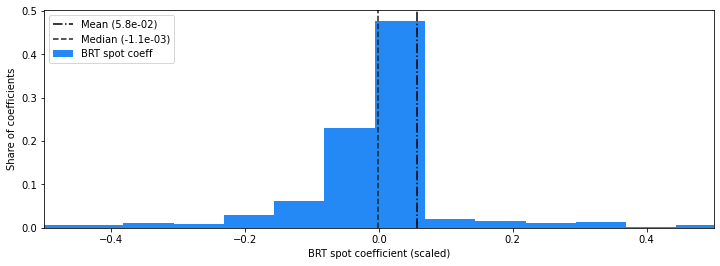

In [ ]:
mean = brt_coeff.mean()
medi = np.median(brt_coeff)

print("Mean:", mean, "Median:", medi)

plt.hist(brt_coeff, bins=500, weights=np.ones(len(brt_coeff)) / len(brt_coeff), label="BRT spot coeff");
plt.axvline(x=mean, color="black", linestyle="-.", label=f"Mean ({mean:.1e})")
plt.axvline(x=np.median(brt_coeff), color="#222", linestyle="--", label=f"Median ({medi:.1e})")
plt.xlim(-0.5, 0.5);
plt.xlabel("BRT spot coefficient (scaled)")
plt.ylabel("Share of coefficients")
plt.legend(loc=2);

## Average absolute impact per individual coefficient

In [ ]:
coeffs = defaultdict(dict)

for ticker, (model, columns) in tqdm(sorted(models.items(), key=lambda x: len(x[1][1]), reverse=True)):
    for idx, col in enumerate(columns):
        coeffs[col][ticker] = model.model_.params()[idx]
len(coeffs)

100%|██████████| 809/809 [00:00<00:00, 5801.29it/s]


24

In [ ]:
coeff_df = pd.DataFrame(coeffs).rename(columns={"eur": "eur_fx", "gbp": "gbp_fx", "cny": "cny_fx"})
coeff_df.isna().sum(axis=0) / coeff_df.shape[0]

revenue                      0.159456
gross_profit                 0.203956
ebitda                       0.087763
ebit                         0.087763
net_income                   0.096415
total_assets                 0.106304
total_current_assets         0.106304
total_liabilites             0.108776
total_current_liabilities    0.110012
long_term_debt_p_assets      0.318912
short_term_debt_p_assets     0.650185
fcf                          0.197775
gross_profit_p               0.207664
ebitda_p                     0.161928
ebit_p                       0.161928
net_income_p                 0.169345
brt                          0.000000
clc                          0.000000
wtc                          0.000000
lng                          0.001236
vix                          0.000000
eur_fx                       0.000000
gbp_fx                       0.000000
cny_fx                       0.000000
dtype: float64

In [ ]:
denom_df = pd.DataFrame(index=coeff_df.index, columns=coeff_df.columns)

for ticker in tqdm(coeff_df.index):

    ys, exs = get_arimax_training_data(stck, fund, macr, ticker, 240)
    denom_df.loc[ticker, :] = ys.mean() / exs.mean(axis=0, skipna=True)

denom_df

100%|██████████| 809/809 [00:22<00:00, 36.67it/s]


,revenue,gross_profit,ebitda,ebit,net_income,total_assets,total_current_assets,total_liabilites,total_current_liabilities,long_term_debt_p_assets,...,ebit_p,net_income_p,brt,clc,wtc,lng,vix,eur_fx,gbp_fx,cny_fx
000159.SZ,14.21774,97.062298,-624.053675,-624.053675,-251.25537,0.712707,1.202728,2.606939,2.951618,196501140.276914,...,-4563860384.980545,-2542761633.181752,4397230.333364,4816725.802737,4817940.9875,32063931.22287,18563420.666049,264483134.000157,233927778.041083,47119062.513022
000554.SZ,4.224383,52.214505,764.596078,764.596078,9306.877289,2.349505,9.984808,7.777427,8.241654,721821169.052027,...,81043566620.942062,1034815555819.22168,6523249.620538,7145567.182719,7147369.897824,47566538.781365,27538659.027456,392358228.409065,347029646.766867,69900683.693103
000937.SZ,3.018769,14.04864,27.373519,27.373519,49.877116,0.352609,0.887218,0.659636,1.12847,127935417.11938,...,22363188845.744347,40753913605.152168,34715132.85103,38026954.12162,38036547.728795,253137440.557218,146553981.87852,2088034157.321229,1846806575.181278,371994276.157084
000983.SZ,3.100296,11.149412,23.669852,23.669852,41.647504,0.402577,1.332056,0.647161,1.035503,158967842.881939,...,27544526535.745609,48510354039.697693,50778235.403525,55622475.545541,55636508.228221,370267128.206557,214366242.614869,3054192257.481464,2701345820.041949,544120427.380345
002202.SZ,7.773578,26.46283,61.284266,61.284266,58.525348,0.632736,1.434451,0.937274,1.632472,300473828.29949,...,57416611769.117485,57217077835.114006,100214271.549174,109774706.116927,109802400.562422,730747144.656567,423066234.532667,6027654364.558448,5331288127.809155,1073858353.51737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SWCO.SI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,457864.933308,491715.392821,491375.419324,3427305.757958,2186013.877793,22241974.610693,19605970.334169,3860777.761834
UPET.BX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,26601.219207,29117.140726,29121.76093,195815.026193,112301.520345,1607479.256803,1421818.214676,286424.734279
VQC.HNO,1.62809,7.154339,10.911636,67.089277,NaN,NaN,NaN,NaN,NaN,NaN,...,72776849.474108,NaN,23941.344192,26238.543712,26246.500658,175816.216403,100743.251431,1447748.005123,1280259.608404,257396.819979
VVO.L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,29535406.104679,32740881.758842,32751088.430608,209568200.285082,131915885.034994,1851456791.860244,1641910548.18159,316227798.126609


In [81]:
coeffs.mean(axis=0, skipna=True) > 1

revenue                       True
gross_profit                  True
ebitda                        True
ebit                          True
net_income                    True
total_assets                 False
total_current_assets          True
total_liabilites              True
total_current_liabilities     True
long_term_debt_p_assets      False
short_term_debt_p_assets     False
fcf                          False
gross_profit_p               False
ebitda_p                     False
ebit_p                       False
net_income_p                 False
brt                          False
clc                          False
wtc                          False
lng                          False
vix                          False
eur_fx                       False
gbp_fx                       False
cny_fx                       False
dtype: bool

In [126]:
coeffs = (coeff_df / denom_df)

coeffs = coeffs[coeffs.abs() < 1e10]
coeffs = coeffs.loc[:, coeffs.mean(axis=0, skipna=True).abs() > 1]

mean_coeff = coeffs.mean(axis=0, skipna=True).sort_values(ascending=False)
std_coeff = coeffs.std(axis=0, skipna=True)[mean_coeff.index]

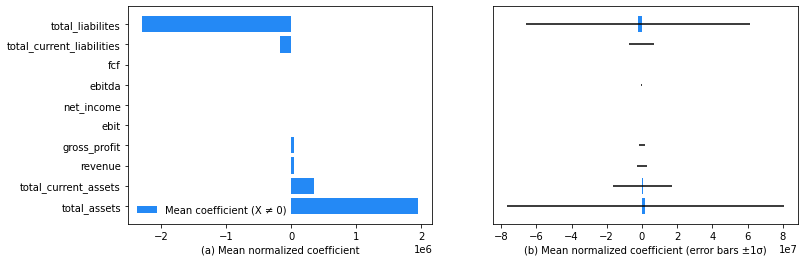

In [127]:
mpl.rcParams['figure.figsize'] = (12, 4)

fig, (ax1, ax2) = plt.subplots(ncols=2)


ax1.barh(mean_coeff.index, mean_coeff.values, label="Mean coefficient (X ≠ 0)")
ax2.barh(mean_coeff.index, mean_coeff.values, xerr=std_coeff)
ax2.yaxis.set_visible(False)

ax1.set_xlabel("(a) Mean normalized coefficient")
ax2.set_xlabel("(b) Mean normalized coefficient (error bars ±1σ)")

ax1.legend(frameon=False);

#plt.xlabel("Mean change in predicted market cap")
#plt.legend(frameon=False);

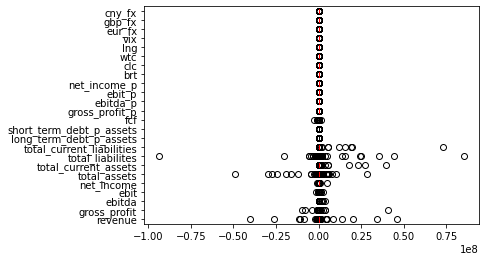

In [71]:
plt.boxplot(coeffs.values, labels=coeff_df.columns, vert=False);

# Initial experiments

The below experiments were performed in order to get familiarized with the `pmdarima` library and included here for reference.

## A little real-world data

Take one company (Aker BP) and prepare the data and test one ARIMAX-model.

In [ ]:
%%capture
stck = get_dataset("stock-oil-final:v4", "master-test")
fund = get_dataset("fundamentals-oil-final:v4", "master-test").astype({"date": np.datetime64, "period_end_date": np.datetime64, "announce_date": np.datetime64})
meta = get_dataset("meta-oil-final:v4", "master-test")

### Prepare the data

In [ ]:
ticker = "AKRBP.OL"

aker_s = stck[(stck.ticker == ticker) & (stck.date >= "2018-01-01")].set_index("date")
print(aker_s.shape)
aker_s.head()

(1078, 4)


,ticker,market_cap,close_price,currency
date,,,,
2018-01-02,AKRBP.OL,9049035666.637951,25.128287,USD
2018-01-03,AKRBP.OL,9200288357.99711,25.548301,USD
2018-01-04,AKRBP.OL,9298265319.07136,25.820374,USD
2018-01-05,AKRBP.OL,9380450069.769461,26.048593,USD
2018-01-08,AKRBP.OL,9417996570.013371,26.152856,USD


In [ ]:
aker_f = (
    fund[(fund.ticker == ticker) & (fund.announce_date >= "2018-01-01")]
    .set_index("announce_date")
    .drop(columns=["period_end_date"])
)

aker_f = aker_f.sort_index()
aker_f = aker_f[~aker_f.index.duplicated(keep="last")]

print(aker_f.shape)
aker_f.head()

(13, 18)


,ticker,date,revenue,gross_profit,ebitda,ebit,net_income,total_assets,total_current_assets,total_liabilites,total_current_liabilities,long_term_debt_p_assets,short_term_debt_p_assets,fcf,gross_profit_p,ebitda_p,ebit_p,net_income_p
announce_date,,,,,,,,,,,,,,,,,,
2018-02-02,AKRBP.OL,2017-12-31,725994000.0,578918000.0,509189000.0,326051000.0,34037000.0,12018560000.0,2532069000.0,9029964000.0,2888476000.0,15.74727,12.45053,266124000.0,0.797414,0.701368,0.449110,0.046883
2019-04-26,AKRBP.OL,2019-03-31,836262000.0,635800000.0,538582000.0,355479000.0,10426000.0,11116582000.0,618708000.0,8317118000.0,1443653000.0,22.50158,0.0,100244000.0,0.760288,0.644035,0.425081,0.012467
2019-07-12,AKRBP.OL,2019-06-30,784816000.0,586496000.0,522353000.0,354464000.0,62498000.0,11492580000.0,603432000.0,8828783000.0,1390355000.0,25.12101,0.0,-114713000.0,0.747304,0.665574,0.451652,0.079634
2019-10-22,AKRBP.OL,2019-09-30,723338000.0,556071000.0,479821000.0,273954000.0,-43423000.0,11726805000.0,578073000.0,9283266000.0,1530037000.0,24.99394,0.12791,-167192000.0,0.768757,0.663343,0.378736,-0.060031
2020-02-11,AKRBP.OL,2019-12-31,1002672000.0,848400000.0,745169000.0,490153000.0,111550000.0,12226786000.0,718603000.0,9859201000.0,1715361000.0,26.68453,0.12791,-6592000.0,0.846139,0.743183,0.488847,0.111253


In [ ]:
aker_m = meta[(meta.ticker == ticker)]
aker_m.head()

,ticker,exchange_code,region_hq,country_hq,state_province_hq,founding_year,economic_sector,business_sector,industry_group,industry,activity
241,AKRBP.OL,XOSL,Europe,Norway,AKERSHUS,2006,Energy,Energy - Fossil Fuels,Oil & Gas,Oil & Gas Exploration and Production,Oil & Gas Exploration and Production (NEC)


In [ ]:
joined = aker_s.join(aker_f, how="left", rsuffix="_fund")

In [ ]:
joined = joined.ffill()
joined = joined[~joined.revenue.isna()].copy()
joined.head()

,ticker,market_cap,close_price,currency,ticker_fund,date,revenue,gross_profit,ebitda,ebit,...,total_current_assets,total_liabilites,total_current_liabilities,long_term_debt_p_assets,short_term_debt_p_assets,fcf,gross_profit_p,ebitda_p,ebit_p,net_income_p
date,,,,,,,,,,,,,,,,,,,,,
2018-02-02,AKRBP.OL,10163724135.478701,28.223668,USD,AKRBP.OL,2017-12-31,725994000.0,578918000.0,509189000.0,326051000.0,...,2532069000.0,9029964000.0,2888476000.0,15.74727,12.45053,266124000.0,0.797414,0.701368,0.44911,0.046883
2018-02-05,AKRBP.OL,9891561424.55262,27.467899,USD,AKRBP.OL,2017-12-31,725994000.0,578918000.0,509189000.0,326051000.0,...,2532069000.0,9029964000.0,2888476000.0,15.74727,12.45053,266124000.0,0.797414,0.701368,0.44911,0.046883
2018-02-06,AKRBP.OL,9429975035.055611,26.186119,USD,AKRBP.OL,2017-12-31,725994000.0,578918000.0,509189000.0,326051000.0,...,2532069000.0,9029964000.0,2888476000.0,15.74727,12.45053,266124000.0,0.797414,0.701368,0.44911,0.046883
2018-02-07,AKRBP.OL,9577268822.42494,26.595139,USD,AKRBP.OL,2017-12-31,725994000.0,578918000.0,509189000.0,326051000.0,...,2532069000.0,9029964000.0,2888476000.0,15.74727,12.45053,266124000.0,0.797414,0.701368,0.44911,0.046883
2018-02-08,AKRBP.OL,9345333280.791651,25.951077,USD,AKRBP.OL,2017-12-31,725994000.0,578918000.0,509189000.0,326051000.0,...,2532069000.0,9029964000.0,2888476000.0,15.74727,12.45053,266124000.0,0.797414,0.701368,0.44911,0.046883


In [ ]:
trn = get_train_set(joined, limit=120)

tst = get_1_month_test_set(joined)
trn.shape[0], tst.shape[0]

(120, 20)

### Fit ARIMAX

In [ ]:
mod_uni = pm.arima.AutoARIMA(seasonal=False, max_p=10, max_q=10)

ys = trn.market_cap

mod_uni.fit(ys)
print(f"Model residuals: {mod_uni.model_.resid().mean():.3e}")
mod_uni.summary()

Model residuals: 1.182e+08


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2501.048
Date:                Wed, 04 May 2022   AIC                           5006.096
Time:                        12:46:54   BIC                           5011.654
Sample:                             0   HQIC                          5008.353
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.313e+07   2.98e+07     -1.449      0.147   -1.01e+08    1.52e+07
sigma2      1.054e+17      0.005   2.03e+19      0.000    1.05e+17    1.05e+17
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.82   Prob(JB):                         0.81
Heteroskedasticity (H):               2.04   Skew:                             0.11
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [ ]:
mod_mul = pm.arima.AutoARIMA(seasonal=False, with_intercept=False)

ys = trn.market_cap

exs = trn.drop(columns=["ticker", "market_cap", "close_price", "currency", "ticker_fund", "date"]).np()

mod_mul.fit(ys, exs)
print(f"Model residuals: {mod_mul.model_.resid().mean():.3e}")
mod_mul.summary()

Model residuals: 3.767e-06


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                        SARIMAX   Log Likelihood               -2939.431
Date:                Wed, 04 May 2022   AIC                           5912.862
Time:                        12:47:41   BIC                           5960.249
Sample:                             0   HQIC                          5932.106
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0363      0.052      0.701      0.483      -0.065       0.138
x1             0.0289      0.041      0.701      0.483      -0.052       0.110
x2             0.0255      0.036      0.701      0.483      -0.046       0.097
x3             0.0163      0.023      0.701      0.483      -0.029       0.062
x4             0.0017      0.002      0.701      0.483      -0.003       0.006
x5             0.6009      0.857      0.701      0.483      -1.080       2.282
x6             0.1266      0.181      0.701      0.483      -0.227       0.481
x7             0.4515      0.644      0.701      0.483      -0.811       1.714
x8             0.1444      0.206      0.701      0.483      -0.259       0.548
x9          7.873e-10   1.12e-09      0.701      0.483   -1.41e-09    2.99e-09
x10         6.225e-10   8.88e-10      0.701      0.483   -1.12e-09    2.36e-09
x11            0.0133      0.019      0.701      0.483      -0.024       0.051
x12         3.987e-11   5.69e-11      0.701      0.483   -7.16e-11    1.51e-10
x13         3.507e-11      5e-11      0.701      0.483    -6.3e-11    1.33e-10
x14         2.245e-11    3.2e-11      0.701      0.483   -4.03e-11    8.53e-11
x15         2.344e-12   3.34e-12      0.701      0.483   -4.21e-12     8.9e-12
sigma2      2.982e+20   2.31e-23   1.29e+43      0.000    2.98e+20    2.98e+20
===================================================================================
Ljung-Box (L1) (Q):                 112.34   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.00   Prob(JB):                         0.39
Heteroskedasticity (H):               8.61   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.61e+60. Standard errors may be unstable.
"""